# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

## Volatility Models

Volatility is the statistical measure of the dispersion of returns for a given asset. It tells us how much the asset price fluctuates around the mean. In this notebook, you will learn about the different volatility models. You will calculate the different volatilities for the S&P 500 ETF data. 

You will perform the following steps. Calculate the:

1. [Simple Volatility](#sim_vol)
2. [Exponentially Weighted Moving Average Volatility](#ewma)
3. [Average True Range](#ATR)
4. [GARCH Model](#gm)

## Import Libraries

In [1]:
# Import the libraries
import pandas as pd
import numpy as np

# For implementing the ARCH model
from arch import arch_model

# Suppress the warnings
import warnings
warnings.filterwarnings('ignore')

# Visualisation
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

## Read the Data

The price data of the S&P 500 ETF, one minute before the market close, is stored in a CSV file `SPY_15_59_adjusted.csv`. To read a CSV file, you can use the `read_csv` method of `pandas`. After reading the file, calculate the returns using the `pct_change` method on the `close` column.

In [2]:
# The data is stored in the directory 'data_modules'
path = '../data_modules/'

# Read the csv file using read_csv method of pandas
data = pd.read_csv(path + 'SPY_data_15_59.csv', index_col=0)
data.index = pd.to_datetime(data.index)

# Calculate the returns using the close price
data['returns'] = (data['Close'].pct_change()) * 100

# Drop the missing values
data.dropna(inplace=True)

data.head()

,Open,High,Low,Close,Volume,returns
DateTime,,,,,,
2004-01-05 15:59:00,112.38,112.41,112.35,112.37,130500.0,1.234234
2004-01-06 15:59:00,112.60,112.63,112.58,112.63,302300.0,0.231378
2004-01-07 15:59:00,112.83,112.92,112.83,112.89,174300.0,0.230844
2004-01-08 15:59:00,113.34,113.37,113.29,113.32,253900.0,0.380902
2004-01-09 15:59:00,112.54,112.64,112.48,112.51,286000.0,-0.714790


<a id='sim_vol'></a> 
## Simple Volatility

Simple volatility model assigns equal weight to all returns. Let us calculate the rolling estimate of daily volatility. We have taken the rolling window to be 20 days for illustration. 

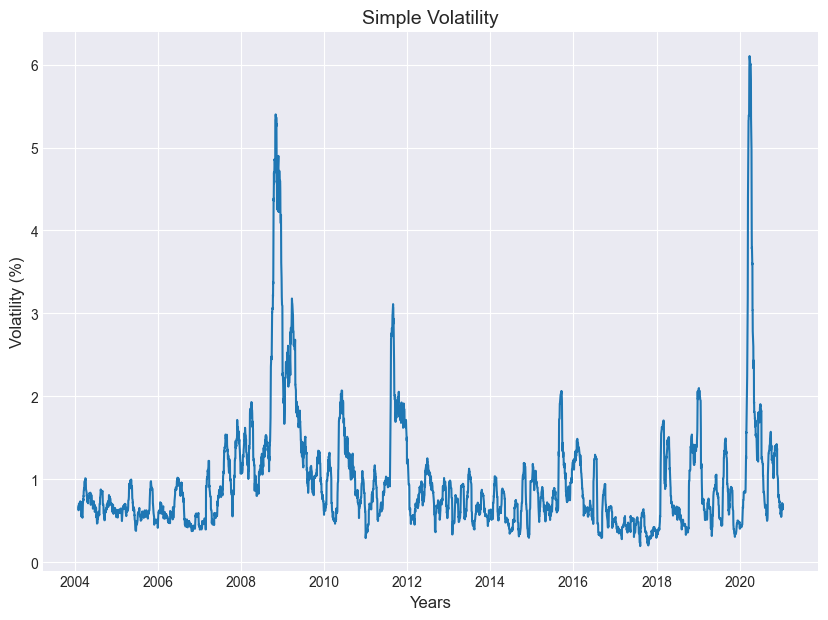

In [3]:
# Simple volatility
data['volatility'] = data['returns'].rolling(20).std()

# Plot the volatility
plt.figure(figsize=(10, 7))
plt.plot(data.index, data.volatility)

# Set the title and axis label
plt.title("Simple Volatility", fontsize=14)
plt.xlabel('Years', fontsize=12)
plt.ylabel('Volatility (%)', fontsize=12)

# Display the plot
plt.show()

In the above plot, you can see that there is a spike in the volatility somewhere in 2008, 2011 and 2020. This indicates the prices were more volatile during this period.

<a id='ewma'></a> 
## Exponentially Weighted Moving Average Volatility

Exponentially weighted moving average volatility model assigns more weight to recent returns and less weight to far away returns. 

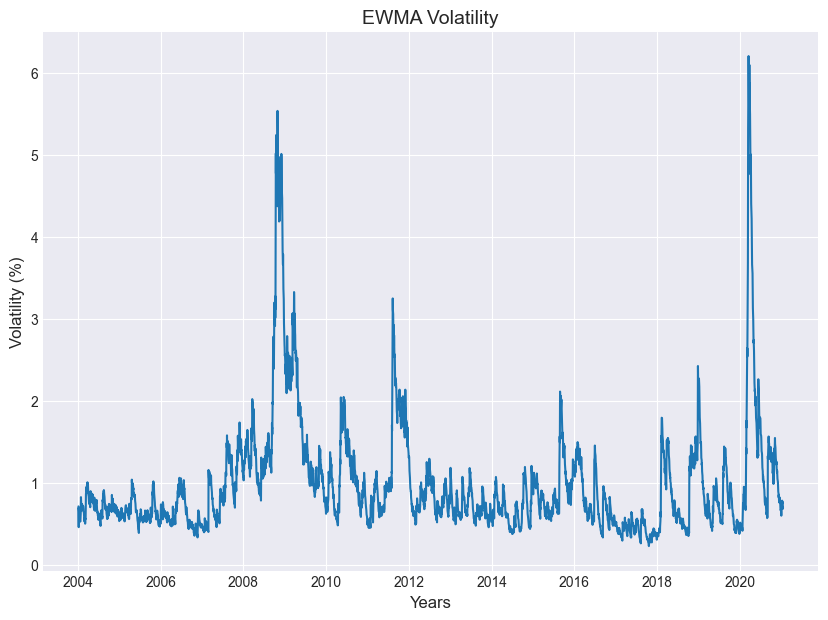

In [4]:
# Exponentially weighted moving average volatility
data['ewma_volatility'] = data['returns'].ewm(span=20).std()

# Plot the volatility
plt.figure(figsize=(10, 7))
plt.plot(data.index, data['ewma_volatility'])

# Set the title and axis label
plt.title("EWMA Volatility", fontsize=14)
plt.xlabel('Years', fontsize=12)
plt.ylabel('Volatility (%)', fontsize=12)

# Display the plot
plt.show()

In the above plot, you can again see the spike during the same time as before. 


<a id='ATR'></a> 
## Average True Range

As the name suggests, average true range or ATR is a volatility indicator that uses the average of true range to indicate the volatility. The true range is defined as:

$$ True \ Range_i = max[(High_i-Low_i),\  |High_i-Close_{prev}|,\  |Low_i-Close_{prev}|]$$

The interpretation of ATR is subjective and depends on the range of the price. ATR should be compared to its previous value. A higher ATR would mean higher volatility.

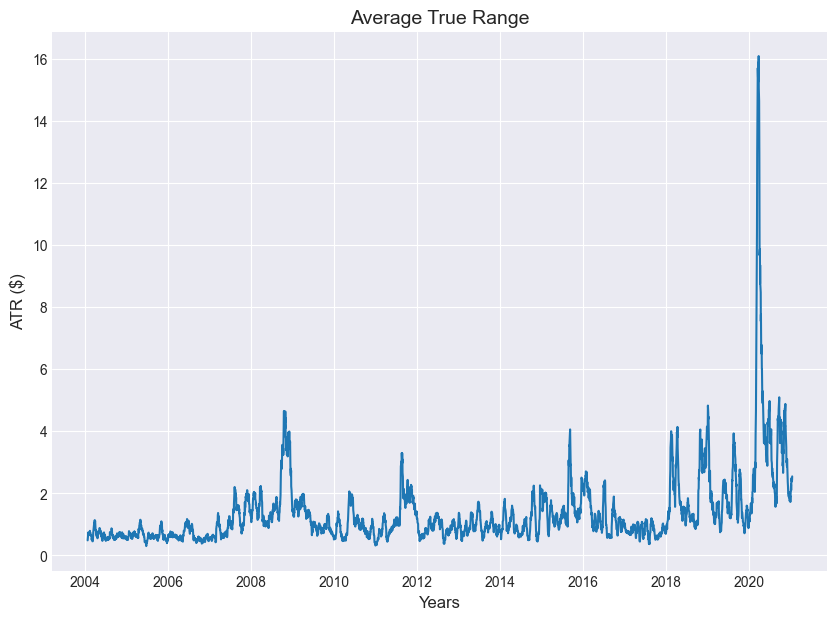

In [5]:
# Calculate the difference of high & low, high & close and low & close
high_low = data['High'] - data['Low']
high_close = np.abs(data['High'] - data['Close'].shift())
low_close = np.abs(data['Low'] - data['Close'].shift())

# Calculate the true range
ranges = pd.concat([high_low, high_close, low_close], axis=1)
true_range = np.max(ranges, axis=1)

# Calculate the rolling estimate of ATR
data['ATR'] = true_range.rolling(14).sum()/14

# Plot the volatility
plt.figure(figsize=(10, 7))
plt.plot(data.index, data.ATR)

# Set the title and axis label
plt.title("Average True Range", fontsize=14)
plt.xlabel('Years', fontsize=12)
plt.ylabel('ATR ($)', fontsize=12)

# Display the plot
plt.show()

You can see a huge spike in the ATR value in 2020. It can be easily concluded that this was due to the outbreak of the COVID pandemic.

<a id='gm'></a> 
## GARCH Model
The GARCH Model is a more advanced method of volatility estimation and is recommended to be used when there are repeated periods of unexplained high volatility in the past data. The best way to account for volatility clustering while making a prediction is to add the volatility from the current time step as the model input. That's exactly what the GARCH model does. It uses past returns and volatility to make a prediction.

The GARCH model in Python is implemented using the `arch_model` function. The syntax is shown below.

Syntax: 
```python
arch_model(historical_data, vol='GARCH', p=AR_order, q=MA_order, dist=distribution_of_the_data)
```
1. `historical_data`: Historical data whose volatility is to be predicted
1. `vol='GARCH'`: Type of model to use
1. `AR_order`: The AR order (p) of the GARCH(p,q) model
1. `MA_order`: The MA order (q) of the GARCH(p,q) model
1. `distribution_of_the_data`: distribution of the input data. Empirically, for most financial data, this is Skewed Student’s t-distribution or 'skewt'

<i>  <span style="color:#FFFF00; background:#00C000"> <b> Running the below cell will take some time. Please be patient. You can also download this notebook from the last section of this course and run it on your local system. Ignore the warnings too, if any.</i>

In [6]:
# Function to predict the volatility of 1 day
def predict_volatility(hist_returns_data):
    # Define model
    gm = arch_model(hist_returns_data, vol='GARCH', p=1, q=1, dist='skewt')

    # Fit the model
    gm_fit = gm.fit(disp='off') 
    
    # Make forecast
    forecasted_variance = gm_fit.forecast(horizon=1).variance.values[-1]

    # Forecasted volatility
    forecasted_volatility = forecasted_variance**0.5

    # Calculate and return the annualised forecasted variance
    annualised_volatility = forecasted_volatility * (252**0.5)
    return annualised_volatility

# Calculate the GARCH predicted volatility for the each day    
data['GARCH_predicted_volatility'] = data['returns'].rolling(252).apply(predict_volatility, raw=True)

# Shift the GARCH predicted volatility to match with the actual historical volatility on each day    
data['GARCH_predicted_volatility'] = data['GARCH_predicted_volatility'].shift(1)

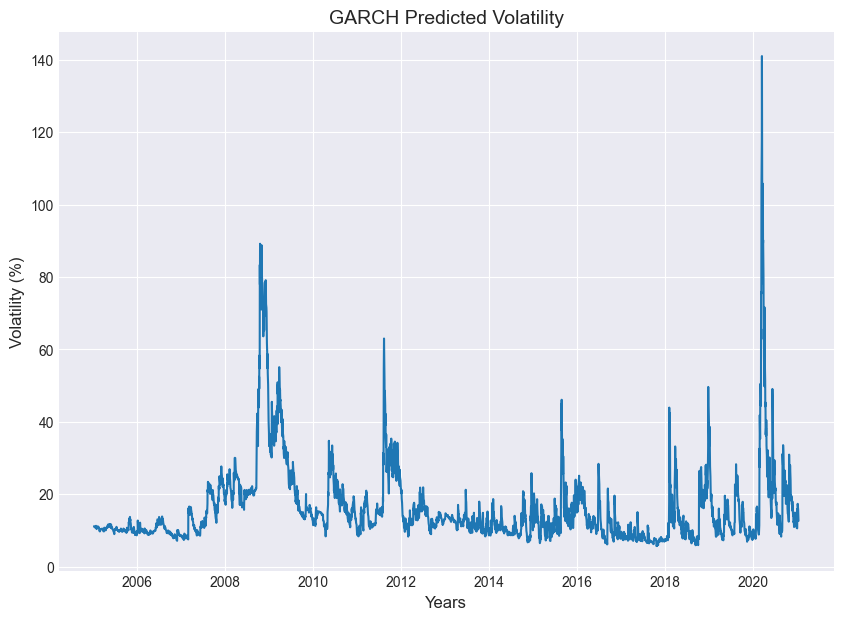

In [7]:
# Plot the volatility
plt.figure(figsize=(10, 7))
plt.plot(data.index, data.GARCH_predicted_volatility)

# Set the title and axis label
plt.title("GARCH Predicted Volatility", fontsize=14)
plt.xlabel('Years', fontsize=12)
plt.ylabel('Volatility (%)', fontsize=12)

# Display the plot
plt.show()

Here, the sudden spike in 2020 was due to the outbreak of Covid-19 and the 2008 spike aligns with the global financial crisis of 2008.

## Tweak the Code

You can use different rolling window to calculate the volatility estimates.

## Conclusion

These are the different ways to calculate the volatility of the price. In the next notebook, you will learn to use this volatility number to determine the position size.
<br><br>